In [113]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import random

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [114]:
env = BlackjackEnv()

In [115]:
Q = defaultdict(lambda: np.zeros(env.action_space.n))
Q[23] = 0
Q[22] = 1
Q[21] = -1
min(Q, key=Q.get)

21

In [116]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA  # creates [0.05, 0.05]
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)  # makes into [0.95, 0.05]
        return A
    return policy_fn

```python
nA = 12
epsilon = 0.2
A = np.ones(nA, dtype=float) * epsilon / nA
A[0] += 1 - epsilon;

sum(A)
```

A clever mathematic approach! Had to think for a while to fully understand what's going on
If you tweak around `nA` and `epsilon` values, you can still see the `sum(A)` turns out to be 1 (or very close)

In [123]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for i in range(1, num_episodes+1):
        if i % 1000 == 0:
            print("\rEpisode {}/{}.".format(i, num_episodes), end="")
            sys.stdout.flush()
        
        episode = []
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)

            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if (x[0] == (state) and x[1] == action))
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        # The policy is improved implicitly by changing the Q dictionary
    
    return Q, policy

In [126]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=1000, epsilon=0.1)

1
2
3
4
5
6
7
8
9
10
11
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
32
33
34
35
36
37
39
40
41
43
44
45
46
47
48
49
50
51
52
53
54
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
78
79
80
81
82
83
84
85
86
87
88
89
90
92
93
94
95
96
97
98
99
100
101
102
103
104
105
107
108
109
110
111
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
145
146
147
148
149
150
151
152
154
156
157
159
160
163
164
165
166
167
168
169
170
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
195
196
197
198
199
200
201
202
203
204
206
207
208
209
211
212
214
215
216
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
236
237
239
240
241
242
243
244
245
246
247
248
249
250
251
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
278
279
280
281
282
283
285
286
288
289
291
292
293
294
296
297
298
299
300
301
302
303
304
306
3

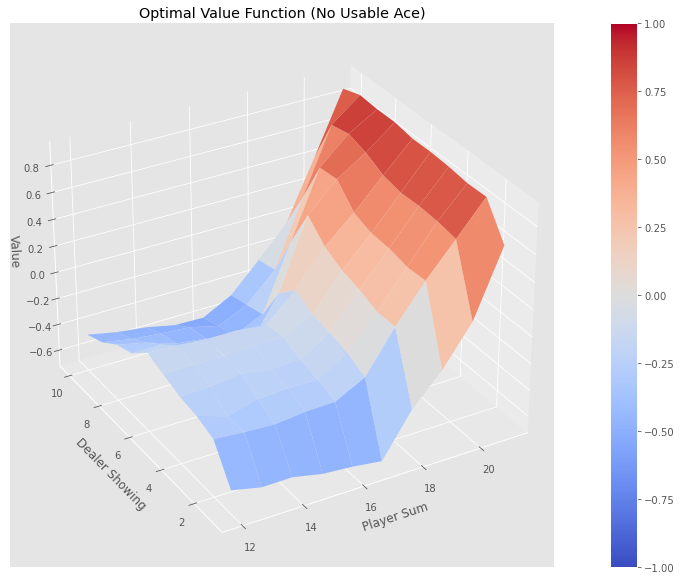

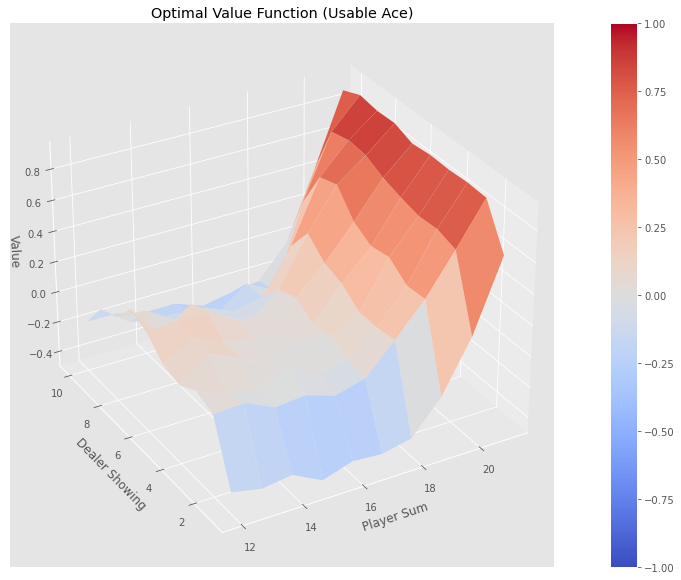

In [119]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")